# Imports

In [1]:
import easydict

import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.autograd.variable import Variable

import torchvision
from torchvision import datasets 
from torchvision import transforms 
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt 
plt.ion();

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

# [Vanilla GAN - 2014](https://github.com/ozanciga/gans-with-pytorch/blob/master/gan/gan.py)

## Generative Adversarial Networks
GAN은 단순히 특정한 이미지를 이해하고 분류하는 것을 넘어서 실제 데이터와 흡사한 가짜 데이터를 생성하는 알고리즘입니다.  GAN은 생성자(Generator) 모델과 구분자(Discriminator) 모델로 두 개의 모델이 학습하는 방식으로 동작합니다.    

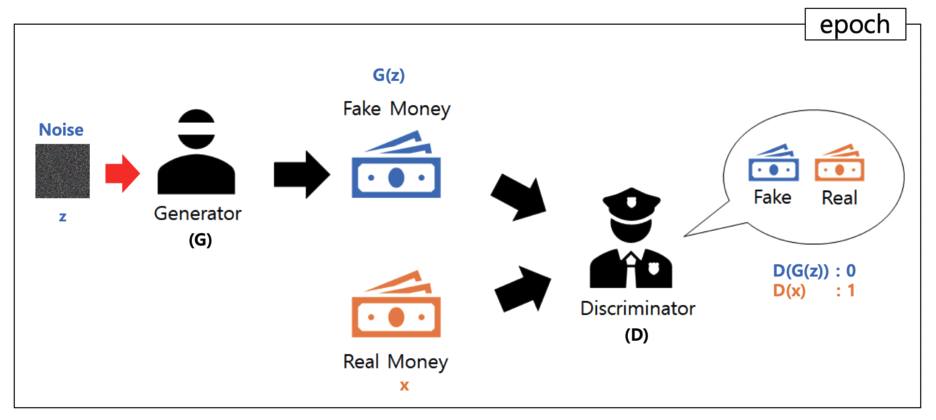

### GAN 학습 과정
1. 구분자 모델은 먼저 진짜 데이터를 진짜로 분류하도록 학습시킵니다. 
2. 다음으로 생성자 모델이 생성한 데이터를 가짜로 분류하도록 학습시킵니다.  
3. 마지막으로 학습된 구분자 모델을 속이는 방향으로 생성자 모델을 학습시킵니다. 

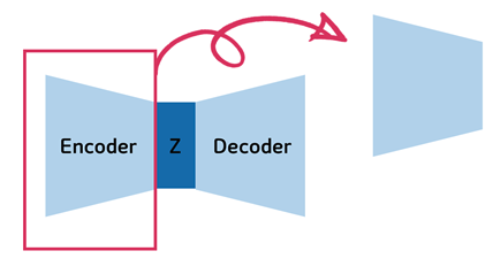

Encoder 부분이 Discriminator 부분이며, Decoder 부분이 Generator가 되는 구조이다.  
- 따라서 Generator는 이미 압축된 저차원의 latent variable의 z가 Generator 네트워크를 통과하게 되면 이미지가 나오게 된다. -> 복원이 되는 것!
- 그러면 방금 복원된 가짜 이미지랑 진짜 이미지(x)가 discriminator network로 들어간다. 
- 이때 D(x)라는 것은 진짜 이미지가 들어간 것이고, D(G(z))는 만들어진 가짜 이미지가 들어간 것이다. 
- Discriminator의 output이 1이면 real, 0이면 fake라고 예측을 한 것이다.
- 즉 Discriminator가 정확하다면 D(x)는 항상 1이어야하고 D(G(z))는 항상 0이라고 답해야 합니다. -> 그게 Discriminator 목적!

## GAN 모델 구조
- Generator: 가짜 사진을 만드는 네트워크
- Discriminator: 진짜와 가짜를 구분할 수 있는 네트워크

이 두가지 네트워크가 서로 경쟁하는 구조이다.

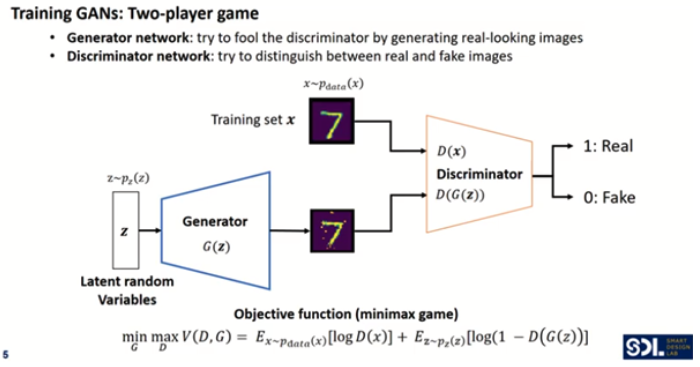

### Objective function / loss function

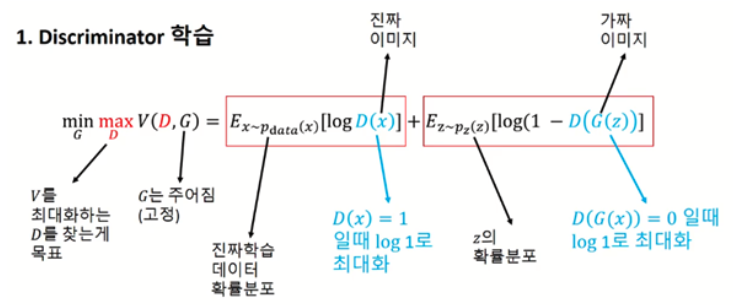

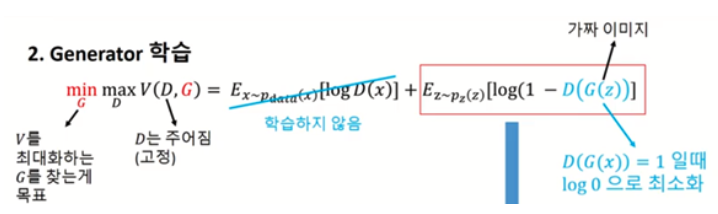

## Model

In [ ]:
opt = easydict.EasyDict()
opt.n_epochs = 200
opt.batch_size = 64
opt.lr = 0.0002
opt.b1 = 0.5
opt.b2 = 0.999
opt.latent_dim = 100
opt.img_size = 28
opt.channels = 1
opt.sample_interval = 512

In [ ]:
img_dims = (opt.channels, opt.img_size, opt.img_size)
n_features = opt.channels * opt.img_size * opt.img_size

img_dims, n_features

((1, 28, 28), 784)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def ganlayer(n_input, n_output, dropout=True):
            pipeline = [nn.Linear(n_input, n_output)]
            pipeline.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout:
                pipeline.append(nn.Dropout(0.25))
            return pipeline

        self.model = nn.Sequential(
            *ganlayer(opt.latent_dim, 128, dropout=False),
            *ganlayer(128, 256),
            *ganlayer(256, 512),
            *ganlayer(512, 1024),
            nn.Linear(1024, n_features),
            nn.Tanh()
        )
        # Tanh > Image values are between [-1, 1]

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_dims)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flatimg = img.view(img.size(0), -1)
        prob = self.model( flatimg )
        return prob

## MNIST Data

In [ ]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
         ])
    output_dir = './data/mnist'
    return datasets.MNIST(root=output_dir, train=True,
                          transform=compose, download=True)

In [ ]:
mnist = mnist_data()
batch_iterator = DataLoader(mnist, shuffle=True, batch_size=opt.batch_size) # List, NCHW format.

## Train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [ ]:
gan_loss = nn.BCELoss()

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_G = optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH 0: BATCH: 937, discrim_loss: 0.5570045709609985, generator_loss: 2.4161806106567383


<ipython-input-78-3ae5c0ff5614>:58: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(int('15{}'.format(i+1)))


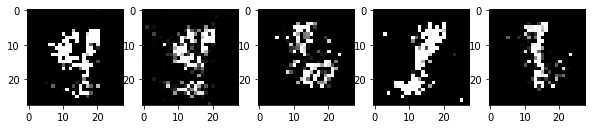

EPOCH 40: BATCH: 937, discrim_loss: 1.0176949501037598, generator_loss: 1.3957908153533936


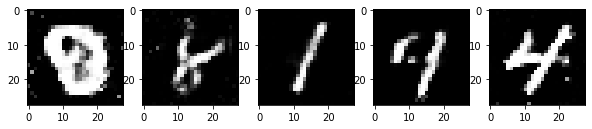

EPOCH 80: BATCH: 937, discrim_loss: 0.7805837392807007, generator_loss: 1.4594156742095947


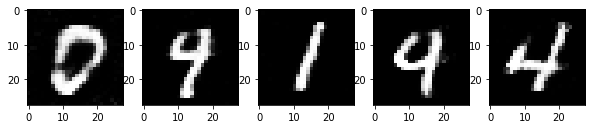

EPOCH 120: BATCH: 937, discrim_loss: 0.7529733180999756, generator_loss: 1.5079059600830078


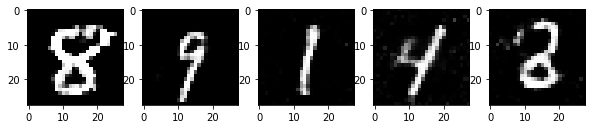

EPOCH 160: BATCH: 937, discrim_loss: 0.9933748841285706, generator_loss: 1.9508516788482666


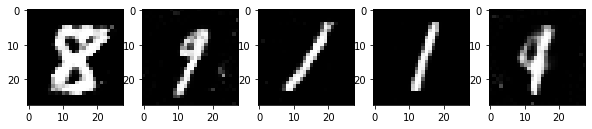

In [ ]:
from tqdm.auto import tqdm

g_losses = []
d_losses = []
testing_random_latent = torch.randn(5, opt.latent_dim).normal_(0, 1).to(device)

for epoch in tqdm(range(opt.n_epochs)):
    # print('Epoch {}'.format(epoch))
    for batch_index, (batch, _) in enumerate(batch_iterator):

        real = torch.ones(batch.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(batch.size(0), 1, requires_grad=False).to(device)

        imgs_real = batch.to(device)
        noise = torch.randn(batch.size(0), opt.latent_dim).normal_(0, 1).to(device)
        imgs_fake = Variable(generator(noise), requires_grad=False)


        # == Discriminator update == #
        optimizer_D.zero_grad()

        # A small reminder: given classes c, prob. p, - c*logp - (1-c)*log(1-p) is the BCE/GAN loss.
        # Putting D(x) as p, x=real's class as 1, (..and same for fake with c=0) we arrive to BCE loss.
        # This is intuitively how well the discriminator can distinguish btw real & fake.
        d_loss = gan_loss(discriminator(imgs_real), real) + \
                 gan_loss(discriminator(imgs_fake), fake)

        d_loss.backward()
        optimizer_D.step()


        # == Generator update == #
        noise = torch.randn(batch.size(0), opt.latent_dim).normal_(0, 1).to(device)
        imgs_fake = generator(noise)

        optimizer_G.zero_grad()

        # Minimizing (1-log(d(g(noise))) is less stable than maximizing log(d(g)) [*].
        # Since BCE loss is defined as a negative sum, maximizing [*] is == minimizing [*]'s negative.
        # Intuitively, how well does the G fool the D?
        g_loss = gan_loss(discriminator(imgs_fake), real)

        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    if epoch % 40 == 0:
        print("EPOCH {}: BATCH: {}, discrim_loss: {}, generator_loss: {}".format(epoch, batch_index, d_loss, g_loss))
        with torch.no_grad():
            testing_fake_images = generator(testing_random_latent)
            testing_fake_images = testing_fake_images.reshape(5, 28, 28).cpu().numpy()
            
            plt.figure(figsize=(10, 5))
            # plt.title("GENERATED IMAGE, EPOCH {}".format(epoch))
            for i in range(5):
                plt.subplot(int('15{}'.format(i+1)))
                plt.imshow(testing_fake_images[i], cmap='gray')
            plt.show()

# [CGAN - 2014](https://github.com/ozanciga/gans-with-pytorch/blob/master/cgan/cgan.py)

## Conditional GAN
- CGAN은 생성자와 판별자가 훈련하는 동안 추가 정보를 사용해 조건이 붙는 생성적 적대 신경망입니다. 
- CGAN을 이용하면 우리가 원하는 class가 담긴 데이터를 생성할 수 있습니다. 
- 생성자와 판별자를 훈련하는 데 모두 label을 사용합니다.

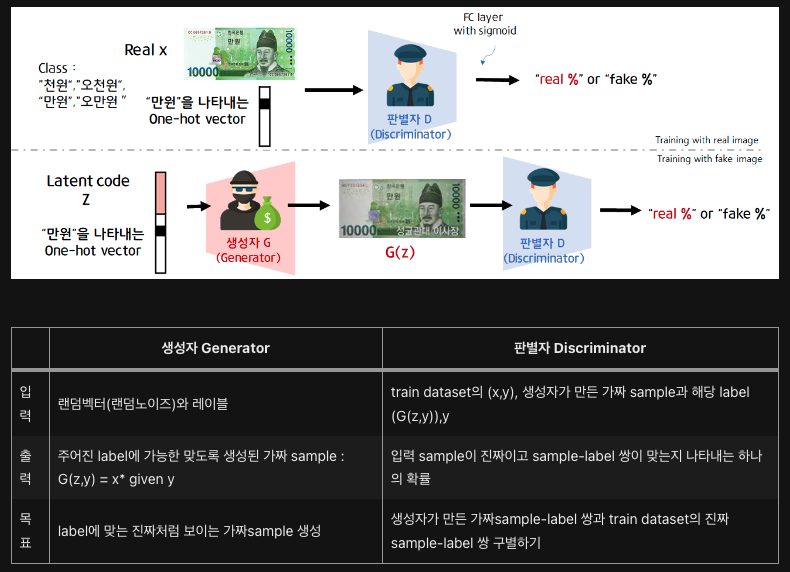

## CGAN 모델 구조

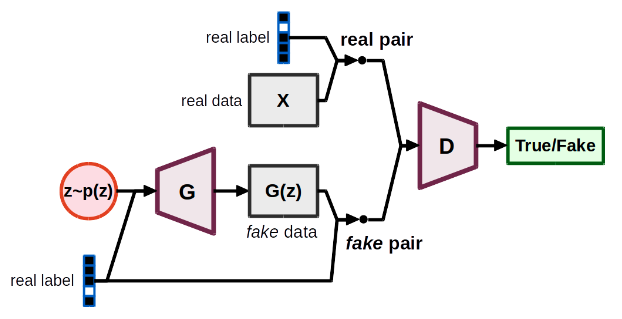

## Model

In [ ]:
opt = easydict.EasyDict()
opt.n_epochs = 400
opt.batch_size = 100
opt.lr = 0.0002
opt.b1 = 0.5
opt.b2 = 0.999
opt.latent_dim = 100
opt.img_size = 28
opt.channels = 1
opt.n_classes = 10
opt.sample_interval = 512

In [ ]:
img_dims = (opt.channels, opt.img_size, opt.img_size)
n_features = opt.channels * opt.img_size * opt.img_size

In [ ]:
def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data, gain=0.02)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data, gain=0.02)
    elif classname.find('BatchNorm1d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Map z & y (noise and label) into the hidden layer.
        # TO DO: How to run this with a function defined here?
        self.z_map = nn.Sequential(
            nn.Linear(opt.latent_dim, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
        )
        self.y_map = nn.Sequential(
            nn.Linear(opt.n_classes, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
        )
        self.zy_map = nn.Sequential(
            nn.Linear(1200, 1200),
            nn.BatchNorm1d(1200),
            nn.ReLU(inplace=True),
        )

        self.model = nn.Sequential(
            nn.Linear(1200, n_features),
            nn.Tanh()
        )
        # Tanh > Image values are between [-1, 1]


    def forward(self, z, y):
        zh = self.z_map(z)
        yh = self.y_map(y)
        zy = torch.cat((zh, yh), dim=1) # Combine noise and labels.
        zyh = self.zy_map(zy)
        x = self.model(zyh)
        x = x.view(x.size(0), *img_dims)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(240, 1),
            nn.Sigmoid()
        )

        # Imitating a 3d array by combining second and third dimensions via multiplication for maxout.
        self.x_map = nn.Sequential(nn.Linear(n_features, 240 * 5))
        self.y_map = nn.Sequential(nn.Linear(opt.n_classes, 50 * 5))
        self.j_map = nn.Sequential(nn.Linear(240 + 50, 240 * 4))

    def forward(self, x, y):
        # maxout for x
        x = x.view(-1, n_features)
        x = self.x_map(x)
        x, _ = x.view(-1, 240, 5).max(dim=2) # pytorch outputs max values and indices
        # .. and y
        y = y.view(-1, opt.n_classes)
        y = self.y_map(y)
        y, _ = y.view(-1, 50, 5).max(dim=2)
        # joint maxout layer
        jmx = torch.cat((x, y), dim=1)
        jmx = self.j_map(jmx)
        jmx, _ = jmx.view(-1, 240, 4).max(dim=2)

        prob = self.model(jmx)
        return prob

## MNIST Data

In [ ]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
         ])
    output_dir = './data/mnist'
    return datasets.MNIST(root=output_dir, train=True,
                          transform=compose, download=True)

In [ ]:
mnist = mnist_data()
batch_iterator = DataLoader(mnist, shuffle=True, batch_size=opt.batch_size) # List, NCHW format.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



## Train

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Weight initialization.
generator.apply(weights_init_xavier)
discriminator.apply(weights_init_xavier)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=240, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (x_map): Sequential(
    (0): Linear(in_features=784, out_features=1200, bias=True)
  )
  (y_map): Sequential(
    (0): Linear(in_features=10, out_features=250, bias=True)
  )
  (j_map): Sequential(
    (0): Linear(in_features=290, out_features=960, bias=True)
  )
)

In [ ]:
gan_loss = nn.BCELoss()

optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_G = optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 0: BATCH: 599, discrim_loss: 1.3680541515350342, generator_loss: 0.7353429794311523
labels: [4, 4, 8, 6, 6]


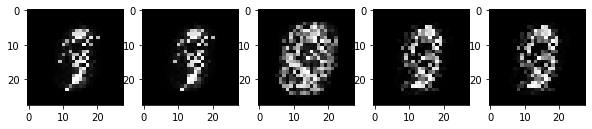

EPOCH 40: BATCH: 599, discrim_loss: 0.9371869564056396, generator_loss: 1.8489534854888916
labels: [8, 5, 3, 6, 3]


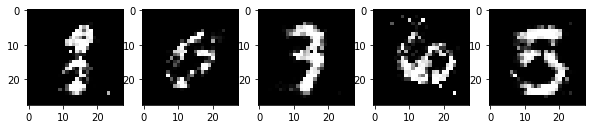

EPOCH 80: BATCH: 599, discrim_loss: 0.6431202292442322, generator_loss: 2.298041343688965
labels: [2, 2, 8, 0, 6]


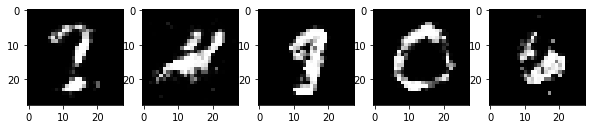

EPOCH 120: BATCH: 599, discrim_loss: 0.691767156124115, generator_loss: 2.1806912422180176
labels: [1, 2, 5, 7, 3]


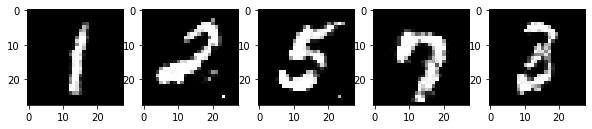

EPOCH 160: BATCH: 599, discrim_loss: 0.5822690725326538, generator_loss: 2.2215652465820312
labels: [3, 7, 1, 3, 1]


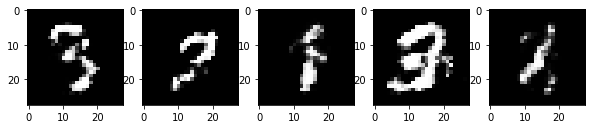

EPOCH 200: BATCH: 599, discrim_loss: 0.6256793737411499, generator_loss: 3.76949143409729
labels: [4, 4, 0, 8, 8]


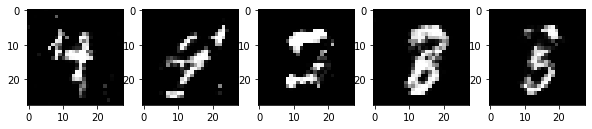

EPOCH 240: BATCH: 599, discrim_loss: 0.5615583658218384, generator_loss: 3.490786552429199
labels: [0, 4, 9, 0, 8]


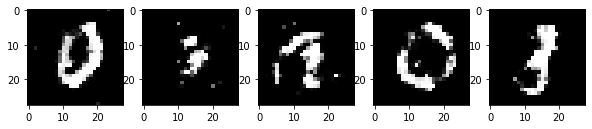

EPOCH 280: BATCH: 599, discrim_loss: 0.440374493598938, generator_loss: 4.405646324157715
labels: [0, 5, 7, 0, 7]


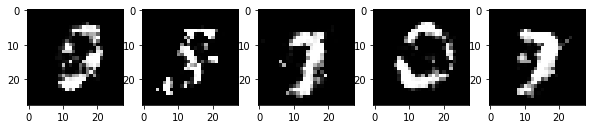

EPOCH 320: BATCH: 599, discrim_loss: 0.5071746110916138, generator_loss: 4.455108642578125
labels: [6, 3, 3, 6, 2]


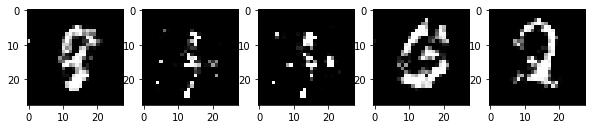

EPOCH 360: BATCH: 599, discrim_loss: 0.4737051725387573, generator_loss: 4.934362888336182
labels: [7, 6, 4, 9, 3]


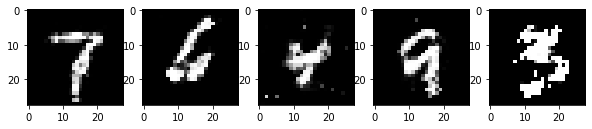

EPOCH 400: BATCH: 599, discrim_loss: 0.415937215089798, generator_loss: 6.9413628578186035
labels: [8, 8, 5, 8, 7]


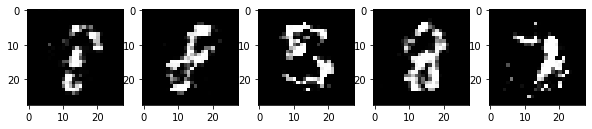

EPOCH 440: BATCH: 599, discrim_loss: 0.40119993686676025, generator_loss: 6.599946022033691
labels: [1, 6, 3, 9, 4]


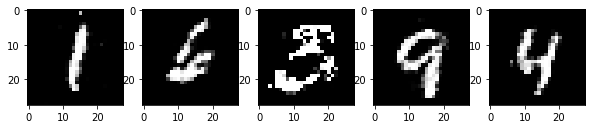

EPOCH 480: BATCH: 599, discrim_loss: 0.44449910521507263, generator_loss: 4.8663787841796875
labels: [5, 8, 8, 4, 8]


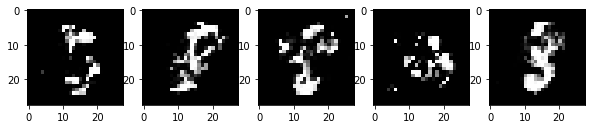

In [ ]:
from tqdm.auto import tqdm

g_losses = []
d_losses = []
testing_random_latent = torch.randn(5, opt.latent_dim).normal_(0, 1).to(device)

for epoch in tqdm(range(opt.n_epochs)):
    for batch_index, (batch, labels) in enumerate(batch_iterator):

        real = torch.ones(batch.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(batch.size(0), 1, requires_grad=False).to(device)

        labels_onehot = torch.zeros(batch.size(0), opt.n_classes).to(device)
        labels_ = labels.long().to(device) # Note: MNIST dataset is given as a longtensor, and we use .type() to feed it into cuda (if cuda available).
        labels_ = labels_.view(batch.size(0), 1)
        labels_onehot = labels_onehot.scatter_(1, labels_, 1) # As of 0.4, we don't have one-hot built-in function yet in pytorch.

        imgs_real = batch.to(device)
        noise = torch.randn(batch.size(0), opt.latent_dim).normal_(0, 1).to(device)
        imgs_fake = generator(noise, labels_onehot)

        # == Discriminator update == #
        optimizer_D.zero_grad()

        # A small reminder: given classes c, prob. p, - c*logp - (1-c)*log(1-p) is the BCE/GAN loss.
        # Putting D(x) as p, x=real's class as 1, (..and same for fake with c=0) we arrive to BCE loss.
        # This is intuitively how well the discriminator can distinguish btw real & fake.
        d_loss = gan_loss(discriminator(imgs_real, labels_onehot), real) + \
                 gan_loss(discriminator(imgs_fake, labels_onehot), fake)

        d_loss.backward()
        optimizer_D.step()


        # == Generator update == #
        noise = torch.randn(batch.size(0), opt.latent_dim).normal_(0, 1).to(device)
        imgs_fake = generator(noise, labels_onehot)

        optimizer_G.zero_grad()

        # Minimizing (1-log(d(g(noise))) is less stable than maximizing log(d(g)) [*].
        # Since BCE loss is defined as a negative sum, maximizing [*] is == minimizing [*]'s negative.
        # Intuitively, how well does the G fool the D?
        g_loss = gan_loss(discriminator(imgs_fake, labels_onehot), real)

        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    if epoch % 40 == 0:
        print("EPOCH {}: BATCH: {}, discrim_loss: {}, generator_loss: {}".format(epoch, batch_index, d_loss, g_loss))
        labels = labels_onehot[:5]
        labels_topk = labels.topk(1)[1].reshape(-1).tolist()
        print(f"labels: {labels_topk}")
        with torch.no_grad():
            testing_fake_images = generator(testing_random_latent, labels)
            testing_fake_images = testing_fake_images.reshape(5, 28, 28).cpu().numpy()
            
            plt.figure(figsize=(10, 5))
            # plt.title("GENERATED IMAGE, EPOCH {}".format(epoch))
            for i in range(5):
                plt.subplot(int('15{}'.format(i+1)))
                plt.imshow(testing_fake_images[i], cmap='gray')
            plt.show()


# [DCGAN - 2015](https://github.com/ozanciga/gans-with-pytorch/blob/master/dcgan/dcgan.py)

## Deep Convolutional GAN
- DCGAN은 CNN 구조로 판별자 D와 생성자 G를 구성한 GAN입니다.
- 판별자 D는 이미지를 입력으로 받아 binary classification을 수행하는 CNN 구조이다.
- 생성자 G는 random vector z를 입력으로 받아 이미지를 생성하는 deconvolutional entwork 구조를 갖게 됩니다. 
- DCGAN의 특징으로는 pooling layer를 사용하지 않고 stride 2이상인 convolution, deconvolution을 사용하였습니다.

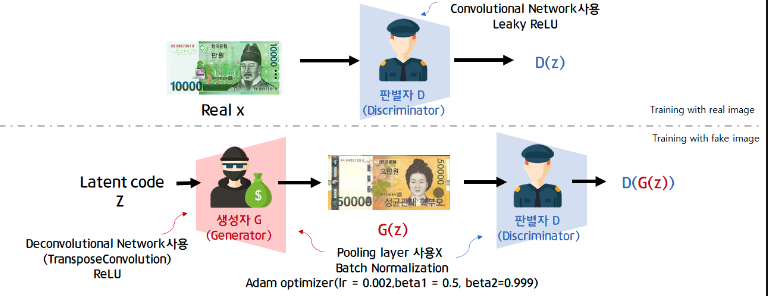

## DCGAN 모델 구조

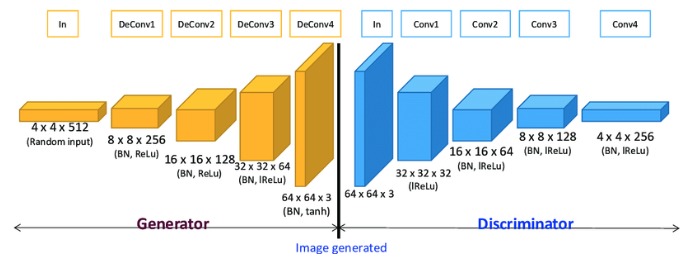

## Model

In [ ]:
opt = easydict.EasyDict()
opt.n_epochs = 1000
opt.batch_size = 64
opt.lr = 0.0001
opt.b1 = 0.5
opt.b2 = 0.999
opt.latent_dim = 100
opt.img_size = 32
opt.channels = 3
opt.n_classes = 10
opt.sample_interval = 64

In [ ]:
img_dims = (opt.channels, opt.img_size, opt.img_size)
n_features = opt.channels * opt.img_size * opt.img_size

In [ ]:
def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(n_output),
            ]
            return block

        self.project = nn.Sequential(
            nn.Linear(opt.latent_dim, 256 * 4 * 4),
            nn.BatchNorm1d(256 * 4 * 4),
            nn.ReLU(inplace=True),
        )

        # pytorch doesn't have padding='same' as keras does.
        # hence we have to pad manually to get the desired behavior.
        # from the manual:
        # o = (i−1)∗s−2p+k, i/o = in/out-put, k = kernel size, p = padding, s = stride.

        self.model = nn.Sequential(
            *convlayer(opt.latent_dim, 256, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(256, 128, 4, 2, 1), # 4->8, (4-1)*2-2p+4 = 8, p = 1
            *convlayer(128, 64, 4, 2, 1), # 8->16, p = 1
            nn.ConvTranspose2d(64, opt.channels, 4, 2, 1),
            nn.Tanh()
        )
        # Tanh > Image values are between [-1, 1]

    def forward(self, z):
        # p = self.project(z)
        # p = p.view(-1, 256, 4, 4) # Project and reshape (notice that pytorch uses NCHW format)
        img = self.model(z)
        img = img.view(z.size(0), *img_dims)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Again, we must ensure the same padding.
        # From the manual:
        # o = (i+2p−d∗(kernel_size−1)−1)/s+1, d = dilation (default = 1).

        self.model = nn.Sequential(
            nn.Conv2d(opt.channels, 64, 4, 2, 1, bias=False), # 32-> 16, (32+2p-3-1)/2 + 1 = 16, p = 1
            nn.LeakyReLU(0.2, inplace=True),
            # nn.BatchNorm2d(64), # IS IT CRUCIAL TO SKIP BN AT FIRST LAYER OF DISCRIMINATOR?
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False), # FC with Conv.
            nn.Sigmoid()
        )

        # we used 3 convolutional blocks, hence 2^3 = 8 times downsampling.
        semantic_dim = opt.img_size // (2**3)

        self.l1 = nn.Sequential(
            nn.Linear(256 * semantic_dim**2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        prob = self.model(img)
        # prob = self.l1(prob.view(prob.size(0), -1))
        return prob

## [CIFAR10 Data](https://www.cs.toronto.edu/~kriz/cifar.html)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
batch_size = 4

trainset = datasets.CIFAR10(root='./data/cifar10', train=True,
                                        download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import numpy as np 

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(f'npimg.shape: {npimg.shape}')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

images.shape, labels.shape

(torch.Size([4, 3, 32, 32]), torch.Size([4]))

npimg.shape: (3, 36, 138)


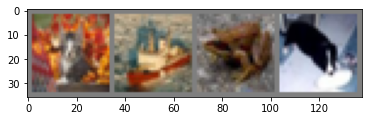

cat   ship  frog  dog  


In [ ]:
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Dataset

In [ ]:
def custom_data(CIFAR_CLASS = 5): # Only working with dogs.
    compose = transforms.Compose(
        [transforms.Resize(opt.img_size),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
         ])
    
    output_dir = './data/cifar10'
    cifar = datasets.CIFAR10(root=output_dir, download=True, train=True,
                          transform=compose)
    
    features = torch.zeros(5000, 3, 32, 32).to(device)
    targets = torch.zeros(5000, 1).to(device)

    it = 0
    for i in range(cifar.__len__()):
        sample = cifar.__getitem__(i)
        if sample[1] == CIFAR_CLASS:
            features[it, ...] = sample[0]
            targets[it] = sample[1]
            it += 1
    return features, targets

In [ ]:
features, targets = custom_data(CIFAR_CLASS=1) # Cars.

Files already downloaded and verified


In [ ]:
batch_iterator = DataLoader(torch.utils.data.TensorDataset(features, targets), shuffle=True, batch_size=opt.batch_size) # List, NCHW format.

In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(batch_iterator)
images, labels = next(dataiter)

In [ ]:
images.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 1]))

In [ ]:
images_ = images[:5].cpu()
labels_ = labels[:5].squeeze().cpu().tolist()

images_.shape, labels_

(torch.Size([5, 3, 32, 32]), [1.0, 1.0, 1.0, 1.0, 1.0])

npimg.shape: (3, 36, 172)


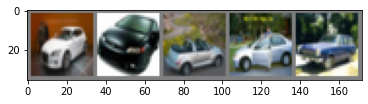

car   car   car   car   car  


In [ ]:
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images_))
print(' '.join(f'{classes[int(labels_[j])]:5s}' for j in range(5)))

### DataLoader

In [ ]:
batch_iterator = DataLoader(torch.utils.data.TensorDataset(features, targets), shuffle=True, batch_size=opt.batch_size) # List, NCHW format.

## Train

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

gan_loss = nn.BCELoss()
optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_G = optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

generator.apply(weights_init_xavier)
discriminator.apply(weights_init_xavier)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
  (l1): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 0: BATCH: 78, discrim_loss: 0.024949826300144196, generator_loss: 4.339744567871094
npimg.shape: (3, 36, 172)


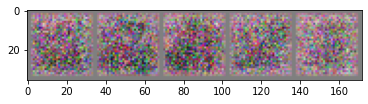

EPOCH 200: BATCH: 78, discrim_loss: 0.6567972302436829, generator_loss: 0.913227915763855
npimg.shape: (3, 36, 172)


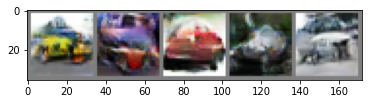

EPOCH 400: BATCH: 78, discrim_loss: 0.37077152729034424, generator_loss: 2.5648036003112793
npimg.shape: (3, 36, 172)


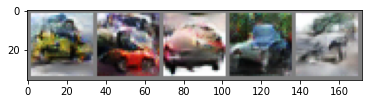

EPOCH 600: BATCH: 78, discrim_loss: 0.05519932880997658, generator_loss: 8.439628601074219
npimg.shape: (3, 36, 172)


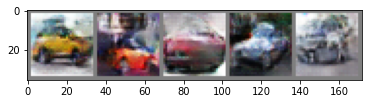

EPOCH 800: BATCH: 78, discrim_loss: 0.6081681847572327, generator_loss: 0.7325872182846069
npimg.shape: (3, 36, 172)


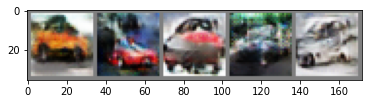

In [ ]:
from tqdm.auto import tqdm

g_losses = []
d_losses = []

testing_random_latent = torch.zeros(5, opt.latent_dim, 1, 1, requires_grad=False).normal_(0, 1).to(device)

for epoch in tqdm(range(opt.n_epochs)):
    
    for batch_index, (batch, _) in enumerate(batch_iterator):

        real = torch.ones(batch.size(0), 1, 1, 1, requires_grad=False).to(device)
        fake = torch.zeros(batch.size(0), 1, 1, 1, requires_grad=False).to(device)

        imgs_real = batch.to(device)
        noise = torch.zeros(batch.size(0), opt.latent_dim, 1, 1, requires_grad=False).normal_(0, 1).to(device)
        imgs_fake = generator(noise)


        # == Discriminator update == #
        optimizer_D.zero_grad()

        # A small reminder: given classes c, prob. p, - c*logp - (1-c)*log(1-p) is the BCE/GAN loss.
        # Putting D(x) as p, x=real's class as 1, (..and same for fake with c=0) we arrive to BCE loss.
        # This is intuitively how well the discriminator can distinguish btw real & fake.
        d_loss = gan_loss(discriminator(imgs_real), real) + \
                 gan_loss(discriminator(imgs_fake), fake)

        d_loss.backward()
        optimizer_D.step()


        # == Generator update == #
        noise = torch.zeros(batch.size(0), opt.latent_dim, 1, 1, requires_grad=False).normal_(0, 1).to(device)
        imgs_fake = generator(noise)

        optimizer_G.zero_grad()

        # Minimizing (1-log(d(g(noise))) is less stable than maximizing log(d(g)) [*].
        # Since BCE loss is defined as a negative sum, maximizing [*] is == minimizing [*]'s negative.
        # Intuitively, how well does the G fool the D?
        g_loss = gan_loss(discriminator(imgs_fake), real)

        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    if epoch % 200 == 0:
        print("EPOCH {}: BATCH: {}, discrim_loss: {}, generator_loss: {}".format(epoch, batch_index, d_loss, g_loss))
        with torch.no_grad():
            testing_fake_images = generator(testing_random_latent)
            testing_fake_images = testing_fake_images.reshape(5, 3, 32, 32)
            imshow(torchvision.utils.make_grid(testing_fake_images.cpu()))


# [InfoGAN - 2016](https://github.com/ozanciga/gans-with-pytorch/blob/master/infogan/infogan.py)

## Information Maximizing GAN
기존 GAN의 생성 모델의 input의 latent variable z 하나인 것에 비해 InfoGAN은 code라는 의미의 latent variable c가 추가되어 G(z,c) 형태로 만들어집니다.   
- z: 더이상 압축할 수 없는 noise.   
- c: latent code라고 부르며 data distribution의 semantic feature를 표현  

여기서 z와 c의 Mutual Information(MI)를 최대화시켜, 기존 GAN과는 차별화된 모습을 보여줍니다.



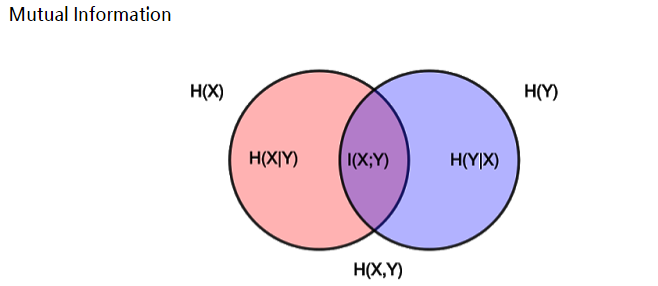

### Mutual Information for Inducing Latent Codes
기존의 GAN모델이 entangled(얽혀있는) representation들을 학습해왔는데, InfoGAN에서는 disentangled(엉킨것이 풀어진) representation들을 학습하는 방법을 제시한다. 이게 무슨 말 이냐면 , 일반적인 GAN은 input에서 noise에 대한 아무런 제약이 없으므로 noise에 대한 정보를 알 수 없다. 즉, noise input 에서 어느부분이 어떤 representation을 조절하는지를 알기 힘들다. 하지만 이것을 disentangle하게 , 다시말하면 해석가능하게(어느부분이 의미를 가지도록) 만들어 핵심적인 representation을 학습 할 수 있게 해준다는 것 이다.

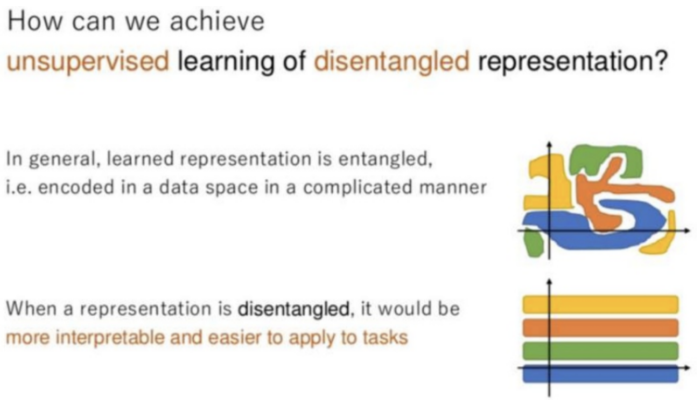

## InfoGAN 모델 구조

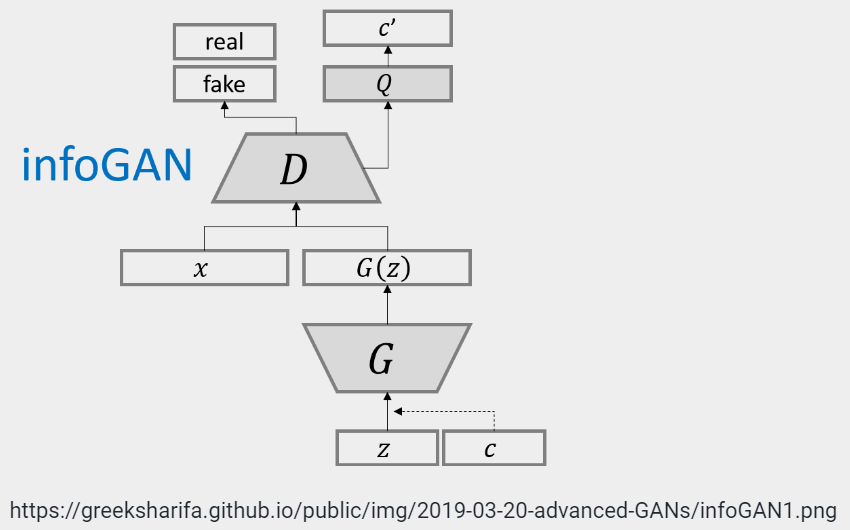

## Model

In [19]:
opt = easydict.EasyDict()
opt.n_epochs = 50  #200
opt.batch_size = 64
opt.d_lr = 0.0002
opt.g_lr = 0.001
opt.b1 = 0.5
opt.b2 = 0.999
opt.latent_dim = 74
opt.lambda_c = 0.1
opt.img_size = 28
opt.channels = 1
opt.n_classes = 10
opt.sample_interval = 64

In [20]:
cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [21]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [22]:
def to_categorical(y):
    """ 1-hot encodes a tensor """
    # return Tensor(torch.eye(10)[y])
    y = LongTensor(y).view(-1, 1)
    y_onehot = Tensor(y.size(0), 10)
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1)
    return y_onehot

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def convlayer(n_input, n_output, k_size=5, stride=2, padding=0, output_padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False, output_padding=output_padding),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.conv_block = nn.Sequential(
            *convlayer(opt.latent_dim, 1024, 1, 1),                     # 1024 x 1 x 1
            *convlayer(1024, 128, 7, 1, 0),                             # 128 x 7 x 7
            *convlayer(128, 64, 4, 2, 1),                               # 64 x 14 x 14
            nn.ConvTranspose2d(64, opt.channels, 4, 2, 1, bias=False),  # 1 x 28 x 28
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, opt.latent_dim, 1, 1)
        img = self.conv_block(z)
        return img

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, normalize=True):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if normalize:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.1, inplace=True))
            return block

        self.model = nn.Sequential(                                     # 1 x 28 x 28
            *convlayer(opt.channels, 64, 4, 2, 1, normalize=False),     # 64 x 14 x 14
            *convlayer(64, 128, 4, 2, 1),                               # 128 x 7 x 7
            *convlayer(128, 1024, 7, 1, 0),                             # 1024 x 1 x 1
        )

        # Regular probability of pertaining to real distribution.
        self.d_head = nn.Sequential(
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

        # Continuous.
        self.q_head_C = nn.Sequential(
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 2)
        )

        # Discrete (digits).
        self.q_head_D = nn.Sequential(
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, img):
        conv_out = self.model(img)
        conv_out = conv_out.squeeze(dim=3).squeeze(dim=2)
        prob = self.d_head(conv_out)
        # Continuous output parameters.
        q = self.q_head_C(conv_out)
        # mu, std = self.q_head_C_mu(q), self.q_head_C_std(q).exp()
        # Discrete outputs.
        digit_probs = self.q_head_D(conv_out)

        return prob, digit_probs, q # mu, std

In [25]:
class GaussianLoss():  # loss pertaining to q(c|x)
    def __call__(self, mu_, std_, x):
        eps = 1e-6
        epsilon = ((x - mu_) / (std_ + eps)) ** 2
        loss = (std_.log() + 0.5 * epsilon)
        loss = torch.mean(loss)

        return loss

## MNIST Data

In [26]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.Resize(opt.img_size),
         transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
         ])
    output_dir = './data/mnist'
    return datasets.MNIST(root=output_dir, train=True,
                          transform=compose, download=True)

In [27]:
mnist = mnist_data()
batch_iterator = DataLoader(mnist, shuffle=True, batch_size=opt.batch_size) # List, NCHW format.

## Train

In [28]:
gan_loss = nn.BCELoss()
discrete_loss = nn.NLLLoss()
continuous_loss = nn.MSELoss() # GaussianLoss()

In [29]:
generator = Generator()
discriminator = Discriminator()

In [30]:
optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.d_lr, betas=(opt.b1, opt.b2))
optimizer_G = optim.Adam(generator.parameters(), lr=opt.g_lr, betas=(opt.b1, opt.b2))

In [31]:
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    gan_loss = gan_loss.cuda()
    discrete_loss = discrete_loss.cuda()
    continuous_loss = continuous_loss.cuda()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.1, inplace=True)
    (5): Conv2d(128, 1024, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (d_head): Sequential(
    (0): Linear(in_features=1024, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (q_head_C): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Linear(in_features=12

In [32]:
noise = Variable(Tensor(100, opt.latent_dim - 10 - 2).normal_(0, 1), requires_grad=False)
digits = Variable(to_categorical([i for i in range(10) for j in range(10)]), requires_grad=False)

c1 = Variable(Tensor(torch.linspace(-1, 1, 10).repeat(10,).data.numpy()).unsqueeze_(1), requires_grad=False)
c2 = Variable(Tensor(100, 1).fill_(0), requires_grad=False)

z_fixed0 = torch.cat((noise, digits, c2, c2), dim=-1)
z_fixed1 = torch.cat((noise, digits, c1, c2), dim=-1)
z_fixed2 = torch.cat((noise, digits, c2, c1), dim=-1)

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 0: BATCH: 937, discrim_loss: 0.6254047155380249, generator_loss: 0.7110844254493713


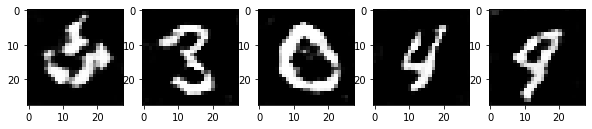

EPOCH 10: BATCH: 937, discrim_loss: 0.4834054708480835, generator_loss: 0.6229633092880249


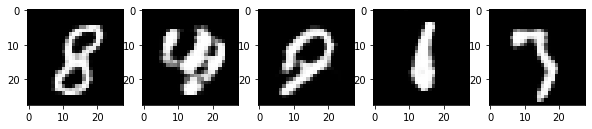

EPOCH 20: BATCH: 937, discrim_loss: 0.3575906753540039, generator_loss: 1.7298946380615234


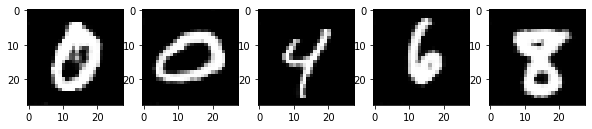

EPOCH 30: BATCH: 937, discrim_loss: 0.44689086079597473, generator_loss: 1.9684126377105713


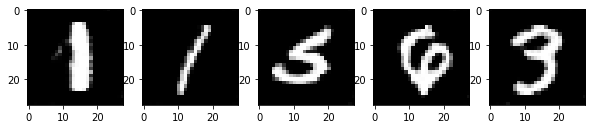

EPOCH 40: BATCH: 937, discrim_loss: 0.18750011920928955, generator_loss: 2.824343681335449


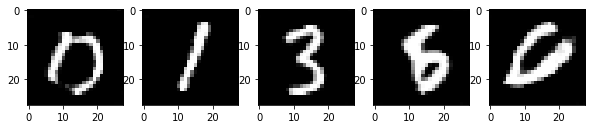

In [33]:
from tqdm.auto import tqdm

for epoch in tqdm(range(opt.n_epochs)):
    for batch_index, (batch, _) in enumerate(batch_iterator):

        real = Variable(Tensor(batch.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(batch.size(0), 1).fill_(0.0), requires_grad=False)

        imgs_real = Variable(batch.type(Tensor))


        # == Discriminator update == #
        optimizer_D.zero_grad()

        noise = Variable(Tensor(batch.size(0), opt.latent_dim - 10 - 2).normal_(0, 1))
        digits = to_categorical(list(torch.randint(0, 9, (batch.size(0), ))))
        cis = Variable(Tensor(batch.size(0), 2).uniform_(-1, 1))  # c_i's (continuous variables)

        z = torch.cat((noise, digits, cis), dim=1)  # [62 noise parameters | 10 one-hot encoding params | c_1 | c_2]

        imgs_fake = generator(z)

        prob_real, _, _ = discriminator(imgs_real)
        prob_fake, _, _ = discriminator(imgs_fake.data)

        d_loss = 0.5*gan_loss(prob_real, real) + 0.5*gan_loss(prob_fake, fake)

        d_loss.backward()
        optimizer_D.step()

        # == Generator update == #
        optimizer_G.zero_grad()

        d_labels = torch.randint(0, 9, (batch.size(0), )).data.numpy()   # Discrete labels (0..9).
        c_labels = Variable(Tensor(batch.size(0), 2).uniform_(-1, 1), requires_grad=False)
        d_targets = Variable(LongTensor(d_labels), requires_grad=False)   # Discrete targets.

        noise = Variable(Tensor(batch.size(0), opt.latent_dim - 10 - 2).normal_(0, 1))
        digits = Variable(to_categorical(d_labels))

        z = torch.cat((noise, digits, c_labels), dim=1)  # [62 noise parameters | 10 one-hot encoding params | c_1 | c_2]

        imgs_fake = generator(z)
        prob_fake, logits, q = discriminator(imgs_fake)

        # Mutual information added loss of InfoGAN.
        g_vanilla_loss = gan_loss(prob_fake, real)
        g_discrete_loss = discrete_loss(logits, d_targets)  # labels, logits.. takes me back... to the horrific tensorflow days.
        g_continuous_loss = continuous_loss(q, c_labels)
        g_loss = g_vanilla_loss + g_discrete_loss + opt.lambda_c*g_continuous_loss

        g_loss.backward()
        optimizer_G.step()

    if epoch % 10 == 0:
        print("EPOCH {}: BATCH: {}, discrim_loss: {}, generator_loss: {}".format(epoch, batch_index, d_loss, g_loss))
        z = torch.cat((noise, digits, c_labels), dim=1)
        with torch.no_grad():
            testing_fake_images = generator(z[:5])
            testing_fake_images = testing_fake_images.reshape(5, 28, 28).cpu().numpy()
            
            plt.figure(figsize=(10, 5))
            # plt.title("GENERATED IMAGE, EPOCH {}".format(epoch))
            for i in range(5):
                plt.subplot(int('15{}'.format(i+1)))
                plt.imshow(testing_fake_images[i], cmap='gray')
            plt.show()

# [WGAN-GP - 2017](https://github.com/ozanciga/gans-with-pytorch/blob/master/wgan-gp/wgan_gp.py)

## Wasserstein GAN(Gradient Penalty)

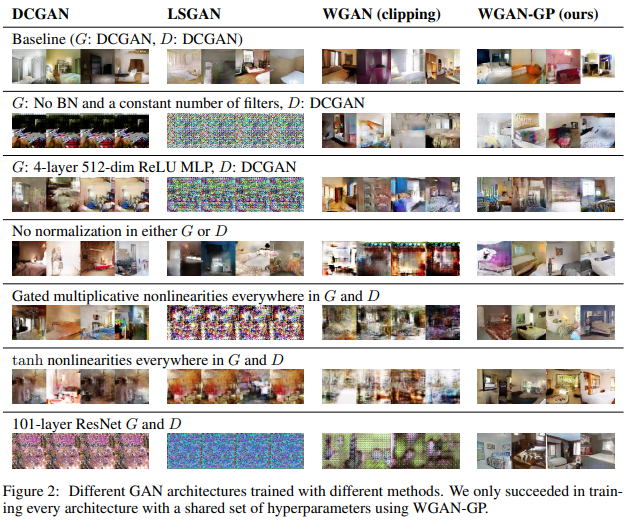

### DCGAN의 한계와 차이점
DCGAN 모델에서 생성자를 판별자의 결과만으로 업데이트 되었기 때문에, 판별자에 비하면 학습이 잘 안될 수 밖에 없다. 그래서 아래와 같이 생성자는 판별자를 잘 속이는 일부 샘플(mode)을 발견하면 그것만 계속 만들어낸다.

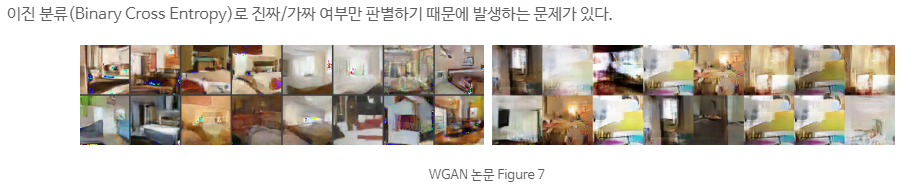

### 새로운 손실 함수

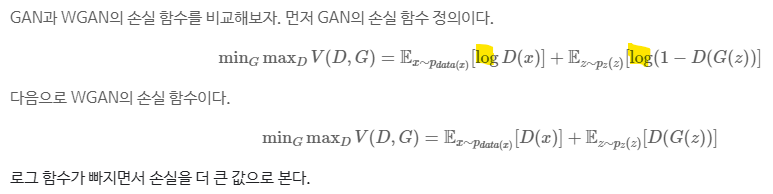

### Gradient Penalty
- 판별자의 마지막 레이어였던 sigmoid 활성화 함수를 제거해서 예측 값의 범위가 $[0,1]$에서 $[-\infty, \infty]$가 된다. 
- 이런 이유로 WGAN의 판별자는 0/1 판별이 아니라 점수를 주다 보니 비평자(Critic)라고 불린다. 
- 비평자의 결과가 $[-\infty, \infty]$ 사이의 값이다 보니, 사실상 손실이 무한으로 나올 수 있다. 이런 문제를 해결한 방법이 Gradient Penalty이다.

첫번째 이미지는 Gradient Penalty를 적용하지 않았을 때, 이미지이며, 두번째 이미지는 적용했을 때의 이미지이다.

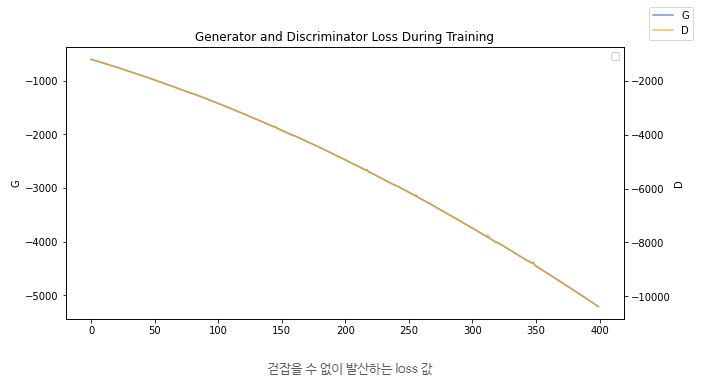

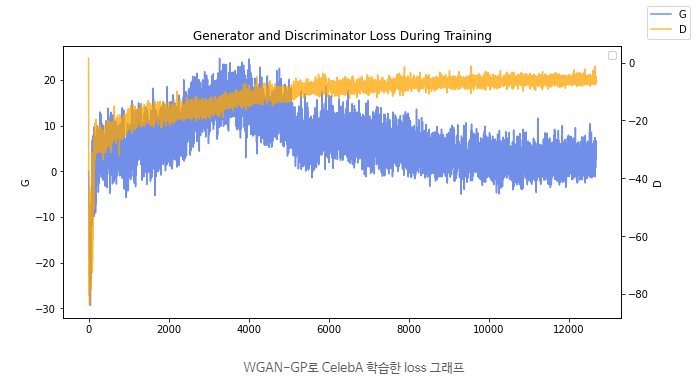

## WGAN-GP 모델 구조

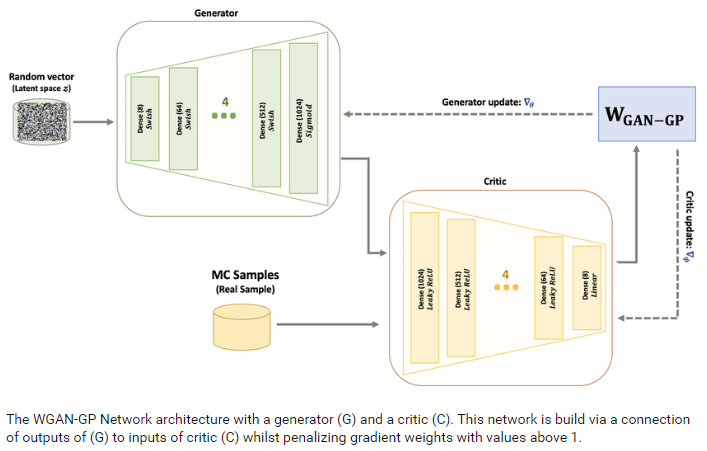

## Model

In [51]:
opt = easydict.EasyDict()
opt.n_epochs = 100
opt.batch_size = 64
opt.alpha = 0.0001
opt.b1 = 0.5
opt.b2 = 0.9
opt.n_critic = 5
opt.lambda_1 = 10
opt.img_size = 32
opt.channels = 3
opt.n_classes = 10
opt.sample_interval = 256

In [52]:
img_dims = (opt.channels, opt.img_size, opt.img_size)
n_features = opt.channels * opt.img_size * opt.img_size

In [53]:
def init_weights(m):
    if type(m) == nn.ConvTranspose2d:
        torch.nn.init.kaiming_normal(m.weight, mode='fan_out', nonlinearity='relu')
    elif type(m) == nn.Conv2d:
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

In [54]:
class MeanPoolConv(nn.Module):
    def __init__(self, n_input, n_output, k_size):
        super(MeanPoolConv, self).__init__()
        conv1 = nn.Conv2d(n_input, n_output, k_size, stride=1, padding=(k_size-1)//2, bias=True)
        self.model = nn.Sequential(conv1)
    def forward(self, x):
        out = (x[:,:,::2,::2] + x[:,:,1::2,::2] + x[:,:,::2,1::2] + x[:,:,1::2,1::2]) / 4.0
        out = self.model(out)
        return out

In [55]:
class ConvMeanPool(nn.Module):
    def __init__(self, n_input, n_output, k_size):
        super(ConvMeanPool, self).__init__()
        conv1 = nn.Conv2d(n_input, n_output, k_size, stride=1, padding=(k_size-1)//2, bias=True)
        self.model = nn.Sequential(conv1)
    def forward(self, x):
        out = self.model(x)
        out = (out[:,:,::2,::2] + out[:,:,1::2,::2] + out[:,:,::2,1::2] + out[:,:,1::2,1::2]) / 4.0
        return out

In [56]:
class UpsampleConv(nn.Module):
    def __init__(self, n_input, n_output, k_size):
        super(UpsampleConv, self).__init__()

        self.model = nn.Sequential(
            nn.PixelShuffle(2),
            nn.Conv2d(n_input, n_output, k_size, stride=1, padding=(k_size-1)//2, bias=True)
        )
    def forward(self, x):
        x = x.repeat((1, 4, 1, 1)) # Weird concat of WGAN-GPs upsampling process.
        out = self.model(x)
        return out

In [57]:
class ResidualBlock(nn.Module):
    def __init__(self, n_input, n_output, k_size, resample='up', bn=True, spatial_dim=None):
        super(ResidualBlock, self).__init__()

        self.resample = resample

        if resample == 'up':
            self.conv1 = UpsampleConv(n_input, n_output, k_size)
            self.conv2 = nn.Conv2d(n_output, n_output, k_size, padding=(k_size-1)//2)
            self.conv_shortcut = UpsampleConv(n_input, n_output, k_size)
            self.out_dim = n_output
        elif resample == 'down':
            self.conv1 = nn.Conv2d(n_input, n_input, k_size, padding=(k_size-1)//2)
            self.conv2 = ConvMeanPool(n_input, n_output, k_size)
            self.conv_shortcut = ConvMeanPool(n_input, n_output, k_size)
            self.out_dim = n_output
            self.ln_dims = [n_input, spatial_dim, spatial_dim] # Define the dimensions for layer normalization.
        else:
            self.conv1 = nn.Conv2d(n_input, n_input, k_size, padding=(k_size-1)//2)
            self.conv2 = nn.Conv2d(n_input, n_input, k_size, padding=(k_size-1)//2)
            self.conv_shortcut = None # Identity
            self.out_dim = n_input
            self.ln_dims = [n_input, spatial_dim, spatial_dim]

        self.model = nn.Sequential(
            nn.BatchNorm2d(n_input) if bn else nn.LayerNorm(self.ln_dims),
            nn.ReLU(inplace=True),
            self.conv1,
            nn.BatchNorm2d(self.out_dim) if bn else nn.LayerNorm(self.ln_dims),
            nn.ReLU(inplace=True),
            self.conv2,
        )

    def forward(self, x):
        if self.conv_shortcut is None:
            return x + self.model(x)
        else:
            return self.conv_shortcut(x) + self.model(x)

In [58]:
class DiscBlock1(nn.Module):
    def __init__(self, n_output):
        super(DiscBlock1, self).__init__()

        self.conv1 = nn.Conv2d(3, n_output, 3, padding=(3-1)//2)
        self.conv2 = ConvMeanPool(n_output, n_output, 1)
        self.conv_shortcut = MeanPoolConv(3, n_output, 1)

        self.model = nn.Sequential(
            self.conv1,
            nn.ReLU(inplace=True),
            self.conv2
        )

    def forward(self, x):
        return self.conv_shortcut(x) + self.model(x)

In [59]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(                     # 128 x 1 x 1
            nn.ConvTranspose2d(128, 128, 4, 1, 0),      # 128 x 4 x 4
            ResidualBlock(128, 128, 3, resample='up'),  # 128 x 8 x 8
            ResidualBlock(128, 128, 3, resample='up'),  # 128 x 16 x 16
            ResidualBlock(128, 128, 3, resample='up'),  # 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 3, 3, padding=(3-1)//2),     # 3 x 32 x 32
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [60]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_output = 128
        '''
        This is a parameter but since we experiment with a single size
        of 3 x 32 x 32 images, it is hardcoded here.
        '''

        self.DiscBlock1 = DiscBlock1(n_output)                      # 128 x 16 x 16

        self.model = nn.Sequential(
            ResidualBlock(n_output, n_output, 3, resample='down', bn=False, spatial_dim=16),  # 128 x 8 x 8
            ResidualBlock(n_output, n_output, 3, resample=None, bn=False, spatial_dim=8),    # 128 x 8 x 8
            ResidualBlock(n_output, n_output, 3, resample=None, bn=False, spatial_dim=8),    # 128 x 8 x 8
            nn.ReLU(inplace=True),
        )
        self.l1 = nn.Sequential(nn.Linear(128, 1))                  # 128 x 1

    def forward(self, x):
        # x = x.view(-1, 3, 32, 32)
        y = self.DiscBlock1(x)
        y = self.model(y)
        y = y.view(x.size(0), 128, -1)
        y = y.mean(dim=2)
        out = self.l1(y).unsqueeze_(1).unsqueeze_(2) # or *.view(x.size(0), 128, 1, 1, 1)
        return out

## CIFAR10 Data

In [61]:
def load_cifar10(img_size):
    compose = transforms.Compose(
        [transforms.Resize(img_size),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
         ])
    output_dir = './data/cifar10'
    cifar = datasets.CIFAR10(root=output_dir, download=True, train=True,
                             transform=compose)
    return cifar

In [62]:
cifar = load_cifar10(opt.img_size)
batch_iterator = DataLoader(cifar, shuffle=True, batch_size=opt.batch_size) # List, NCHW format.

Files already downloaded and verified


## Train

In [66]:
import numpy as np 

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(f'npimg.shape: {npimg.shape}')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [63]:
cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
gan_loss = nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.alpha, betas=(opt.b1, opt.b2))
optimizer_G = optim.Adam(generator.parameters(), lr=opt.alpha, betas=(opt.b1, opt.b2))

In [64]:
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0: BATCH: 781, discrim_loss: -0.9183424115180969, generator_loss: 18.20864486694336
npimg.shape: (3, 36, 172)


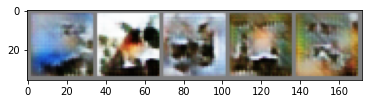

KeyboardInterrupt: ignored

In [67]:
from tqdm.auto import tqdm

g_losses = []
d_losses = []

testing_random_latent = torch.zeros(5, 128, 1, 1, requires_grad=False).normal_(0, 1).to(device)

for epoch in tqdm(range(opt.n_epochs)):
    
    for batch_index, (batch, _) in enumerate(batch_iterator):
        # == Discriminator update == #
        for iter in range(opt.n_critic):
            # Sample real and fake images, using notation in paper.
            x = Variable(batch.type(Tensor))
            noise = Variable(Tensor(batch.size(0), 128, 1, 1).normal_(0, 1))
            x_tilde = Variable(generator(noise), requires_grad=True)

            epsilon = Variable(Tensor(batch.size(0), 1, 1, 1).uniform_(0, 1))

            x_hat = epsilon*x + (1 - epsilon)*x_tilde
            x_hat = torch.autograd.Variable(x_hat, requires_grad=True)

            # Put the interpolated data through critic.
            dw_x = discriminator(x_hat)
            # A great exercise on learning how the autograd.grad works!
            grad_x = torch.autograd.grad(outputs=dw_x, inputs=x_hat,
                                         grad_outputs=Variable(Tensor(batch.size(0), 1, 1, 1).fill_(1.0), requires_grad=False),
                                         create_graph=True, retain_graph=True, only_inputs=True)
            grad_x = grad_x[0].view(batch.size(0), -1)
            grad_x = grad_x.norm(p=2, dim=1) # My naming is inaccurate, this is the 2-norm of grad(D_w(x_hat))

            # Update discriminator (or critic, since we don't output probabilities anymore).
            optimizer_D.zero_grad()

            # WGAN-GP loss, defined properly as a loss unlike the WGAN paper.
            d_loss = torch.mean(discriminator(x_tilde)) - torch.mean(discriminator(x)) + opt.lambda_1*torch.mean((grad_x - 1)**2)
            # d_loss = torch.mean(d_loss) # there's a reason for why this shouldn't be done this way :)

            d_loss.backward()
            optimizer_D.step()

        # == Generator update == #
        noise = Variable(Tensor(batch.size(0), 128, 1, 1).normal_(0, 1))
        imgs_fake = generator(noise)

        optimizer_G.zero_grad()

        g_loss = -torch.mean(discriminator(imgs_fake))

        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    if epoch % 10 == 0:
        print("EPOCH {}: BATCH: {}, discrim_loss: {}, generator_loss: {}".format(epoch, batch_index, d_loss, g_loss))
        with torch.no_grad():
            testing_fake_images = generator(testing_random_latent)
            testing_fake_images = testing_fake_images.reshape(5, 3, 32, 32)
            imshow(torchvision.utils.make_grid(testing_fake_images.cpu()))

# 참고 파일들
- https://github.com/eriklindernoren/PyTorch-GAN
- https://github.com/ozanciga/gans-with-pytorch